The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## step1: camera calibration

用到的opencv函数

1.得到灰度图

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

2.Finding chessboard corners (for an 8x6 board):

ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

3.Drawing detected corners on an image:

img = cv2.drawChessboardCorners(img, (8,6), corners, ret)

4.标定相机Camera calibration

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

objpoints:对象点坐标，3D points in real world space

imgpoints:图像点坐标，2D points in image plane

5.图像矫正：Undistorting a test image:

dst = cv2.undistort(img, mtx, dist, None, mtx)

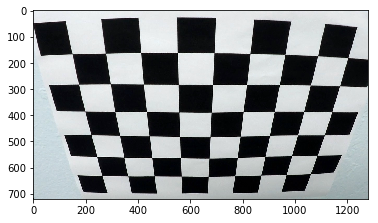

In [73]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

fname = './camera_cal/calibration2.jpg'
img = cv2.imread(fname)

plt.imshow(img)

corners find

### step1: 求角点，标定相机

In [74]:
import glob
# Read in and make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')


# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y


#Arrays to store object points and image points from all the images
objpoints = []  #3D points in real world space
imgpoints= []   #2D points in image plane
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


for fname in images:
    #read in each image
    img = cv2.imread(fname)
     
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        #plt.show()
        


In [75]:
# Read in an image
img = cv2.imread('./test_images/test5.jpg')

## step2: 畸变矫正

In [76]:
img_size = (img.shape[1],img.shape[0])
ret, g_mtx, g_dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

In [77]:
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist

### 测试相机矫正参数

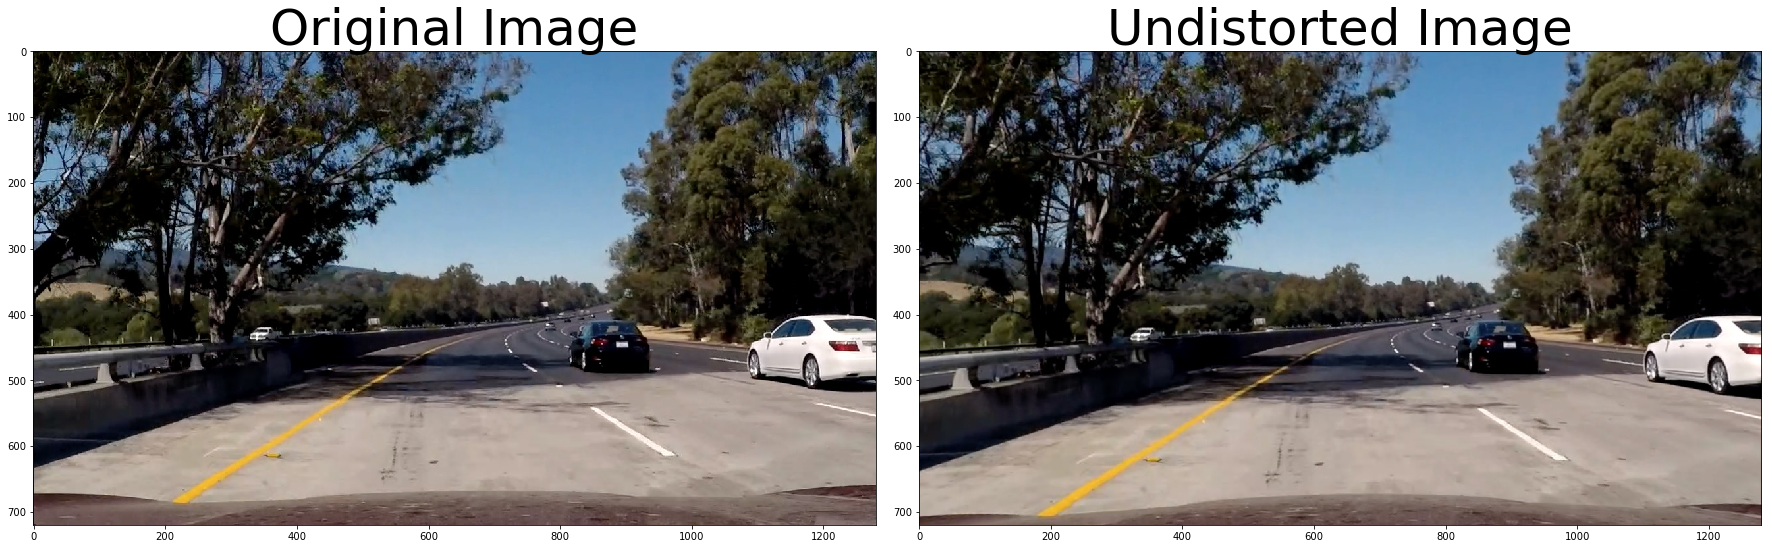

In [78]:
undistorted = cal_undistort(img, g_mtx, g_dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img[:,:,::-1])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted[:,:,::-1])
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## step3 确定ROI

确定ROI(Region of interest),在当前车道线检测项目中,取一个梯形,目的有2:

1.剔除多余目标对车道线检测的干扰;

2.方便透视变换为bird-view图(从梯形转换为矩形);

In [79]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [80]:
print(img_size[0])

1280


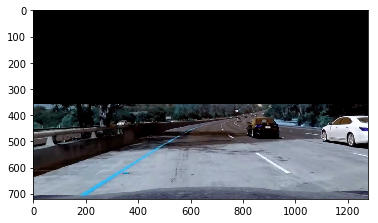

In [83]:
g_vertices = np.array([[(0,img_size[1]),(img_size[0], img_size[1]),((img_size[0]*3)//4, img_size[1]//2), (img_size[0]//4,img_size[1]//2)]], dtype=np.int32)
g_vertices_dst = np.array([[(0,img_size[1]),(img_size[0], img_size[1]),(img_size[0], img_size[1]//2), (0,img_size[1]//2)]], dtype=np.int32)

masked_edges = region_of_interest(undistorted,g_vertices_dst)
plt.imshow(masked_edges[::,:-1])

In [60]:
print(g_vertices)

[[[   0  720]
  [1280  720]
  [ 960  360]
  [ 320  360]]]


## step4: 透视变换

1.求变换矩阵

In [69]:
# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    
    # 1) Undistort using mtx and dist
    img_size = (img.shape[1],img.shape[0])
    undist_img = cv2.undistort(img,mtx,dist,None,mtx)
    #plt.imshow(undist_img)
    
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist_img,cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray,cmap='gray')
    #print(img_size)
    
    # 3) Find the chessboard corners
    #Convert image to grayscale
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
            
    if ret == True:
        img_new = cv2.drawChessboardCorners(undist_img,(nx, ny),corners,ret)
        plt.imshow(img_new)
        print(type(corners),corners.shape)
        #print(corners)
        
        offset = 100
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
        #delete the next two lines
        M = cv2.getPerspectiveTransform(src,dst)
        #warped = np.copy(img) 
        warped = cv2.warpPerspective(undist_img,M,img_size,flags=cv2.INTER_LINEAR)
    else:
        print("find corners failded")
    #b)
    
    return warped, M

<class 'numpy.ndarray'> (54, 1, 2)


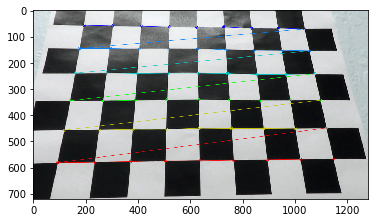

In [70]:
img = cv2.imread('./camera_cal/calibration3.jpg')
top_down, g_perspective_M = corners_unwarp(img, nx, ny, g_mtx, g_dist)

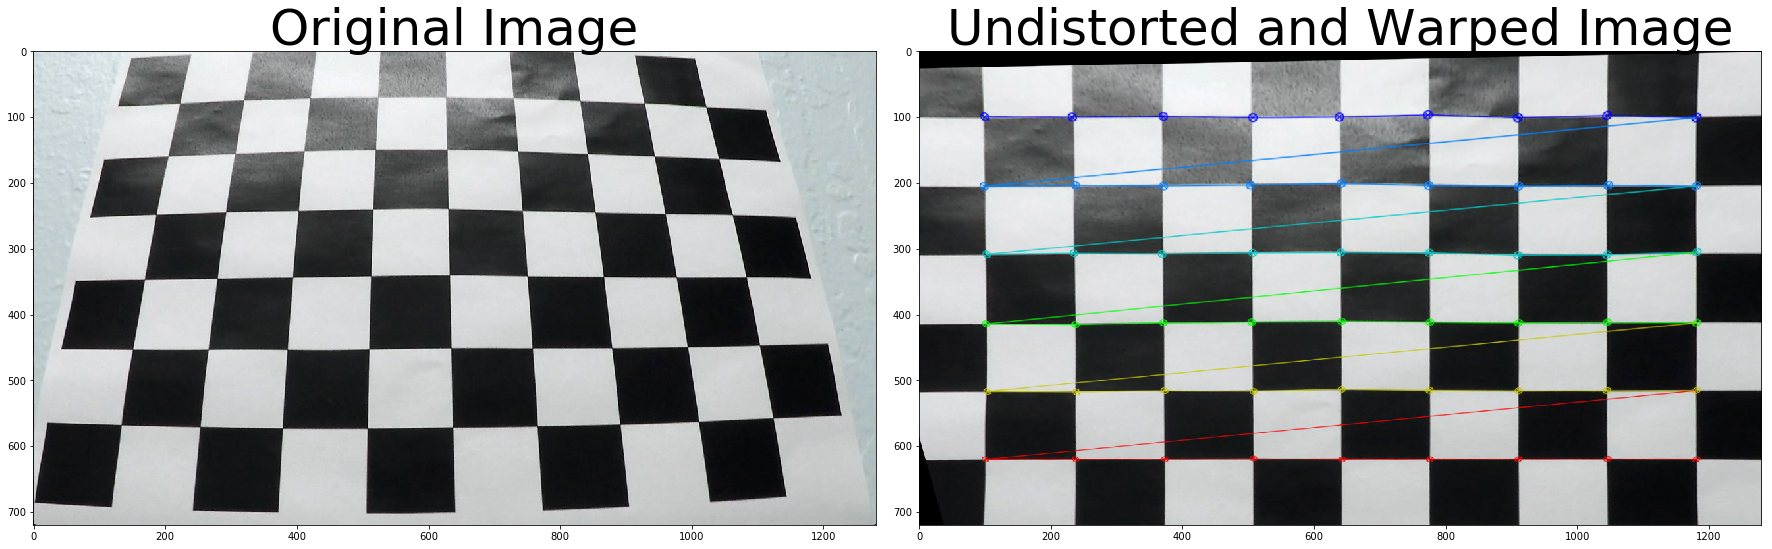

In [71]:
undistorted = cal_undistort(img, g_mtx, g_dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

In [ ]:
offset = 100
src = g_vertices #np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                             [img_size[0]-offset, img_size[1]-offset], 
                             [offset, img_size[1]-offset]])

#delete the next two lines
M = cv2.getPerspectiveTransform(src,dst)
#warped = np.copy(img) 
warped = cv2.warpPerspective(undist_img,M,img_size,flags=cv2.INTER_LINEAR)

In [66]:
def perspective_transform(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


# left_top to left_bottom,
corners = [(603, 445), (677, 445), (1105, 720), (205, 720)]

wrap_offset = 150
src_corners = g_vertices
dst_corners = g_vertices_dst
M = cv2.getPerspectiveTransform(np.float32(src_corners), np.float32(dst_corners))
wrap_img= perspective_transform(straight_lines1, M)

subplot(1, 2, [straight_lines1, wrap_img])


NameError: name 'straight_lines1' is not defined

## step3: 得到车道线阈值图

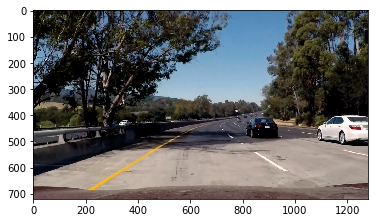

In [65]:

img3 = cv2.imread('./test_images/test5.jpg')
#img3 = cv2.imread('../udacity-project/step1/images/signs_vehicles_xygrad.png')
gray3 = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray3 = cv2.GaussianBlur(gray3,(kernel_size, kernel_size), 0)
plt.imshow(img3[:,:,::-1], cmap='Greys_r')
plt.show()

In [52]:
def abs_sobel_thresh(img, orient,sobel_kernel=3,thresh=(0,255)):
    thresh_min,thresh_max= thresh
    print(thresh_min,thresh_max)
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient =='x':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1))
    
    #print(abs_sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    #print(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

20 200
20 100


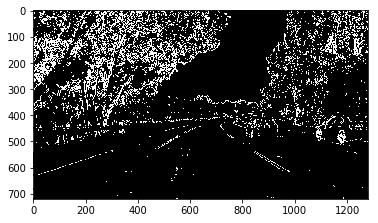

In [61]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img3, orient='x', sobel_kernel=ksize, thresh=(20, 200))
grady = abs_sobel_thresh(img3, orient='y', sobel_kernel=ksize, thresh=(20, 100))
plt.imshow(gradx,cmap='gray')

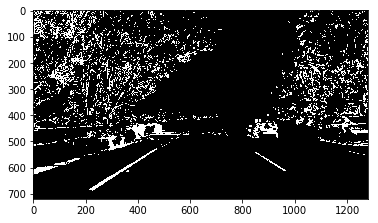

In [60]:
def color_binary(img,dst_format='HLS',ch=2,ch_thresh=[0,255]):
    '''
    Color thresholding on channel ch
    img:RGB
    dst_format:destination format(HLS or HSV)
    ch_thresh:pixel intensity threshold on channel ch
    output is binary image
    '''
    if dst_format =='HSV':
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        ch_binary = np.zeros_like(img[:,:,int(ch-1)])
        ch_binary[(img[:,:,int(ch-1)]>=ch_thresh[0])&(img[:,:,int(ch-1)]<=ch_thresh[1])] = 1
    else:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        ch_binary = np.zeros_like(img[:,:,int(ch-1)])
        ch_binary[(img[:,:,int(ch-1)]>=ch_thresh[0])&(img[:,:,int(ch-1)]<=ch_thresh[1])] = 1
    return ch_binary
ch_thresh = [150,255]
ch3_hls_binary = color_binary(img3,dst_format='HLS',ch=3,ch_thresh=ch_thresh)
plt.imshow(ch3_hls_binary,cmap='gray')

## step4: 视角透视转换，得到bird eye view

## step5: 拟合车道线曲线

## step6: 画出车道线，转换回原图

## step7: 测试视频
